# Udacity AWS ML - project 3

This notebook downloads, trains and deploys the model for dog breed classification

In [3]:
# Install all required packages
!pip install smdebug
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
yes: standard output: Broken pipe
/opt/conda/lib/python3.7/site-packages/secretstora

In [23]:
!pip install torchvision torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [4]:
# Import required packages - further imports will be added later
import sagemaker
import boto3

## Dataset
The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.
Following cells download, preprocess and plot sample of the dataset.
Torch dataset loader was also created to ease teh process of training the network

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-04-12 09:30:30--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.32
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  3.94MB/s    in 1m 49s  

2022-04-12 09:32:20 (9.89 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [5]:
# General macros
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-071394031625
AWS Region: us-east-1
RoleArn: arn:aws:iam::071394031625:role/service-role/AmazonSageMaker-ExecutionRole-20220406T185210


In [6]:
# Create metadata csv files with keys: path, classification to mimic MNIST dataset description.
# It will be easier to create proper dataloader for these data
import os
import csv

def create_metadata(database_path):
    with open(os.path.join(database_path, 'meta.csv'), 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Filename'])
        for root, dirs, files in os.walk(database_path):
            files.sort()
            for file in files:
                if file.lower().endswith('.jpg'):
                    classification_id = int(root.split("/")[2].split(".")[0])-1
                    rel_path = os.path.join(root, file)
                    row = [classification_id, rel_path]
                    writer.writerow(row)
    print('Creating metadata completed for file', os.path.join(database_path, 'meta.csv'))
                    
create_metadata('dogImages/test')
create_metadata('dogImages/train')
create_metadata('dogImages/valid')

Creating metadata completed for file dogImages/test/meta.csv
Creating metadata completed for file dogImages/train/meta.csv
Creating metadata completed for file dogImages/valid/meta.csv


In [7]:
# Create labels map
database_path = 'dogImages'

def create_labels_map(database_path):
    output_filename = os.path.join(database_path, 'labels.csv')
    with open(output_filename, 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Breed name'])
        for root, dirs, files in os.walk(os.path.join(database_path, 'test')):
            dirs.sort()
            for directories in dirs:
                splitted_dir_name = directories.split(".")
                if (len(splitted_dir_name) == 2 and len(splitted_dir_name[0])>0):
                    splitted_dir_name[0] = int(splitted_dir_name[0]) - 1
                    writer.writerow(splitted_dir_name)
            break
    print('Creating labels map completed. Output', output_filename)
    
create_labels_map(database_path)

Creating labels map completed. Output dogImages/labels.csv


In [8]:
# Print statistics about the dataset
import pandas as pd
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')
valid_meta = pd.read_csv('dogImages/valid/meta.csv')
train_meta = pd.read_csv('dogImages/train/meta.csv')

print('There are %d total dog categories.' % len(labels_map))
print('There are %s total dog images.\n' % str(len(test_meta)+len(valid_meta)+len(train_meta)))
print('There are %d training dog images.' % len(train_meta))
print('There are %d validation dog images.' % len(valid_meta))
print('There are %d test dog images.'% len(test_meta))

There are 133 total dog categories.
There are 8364 total dog images.

There are 6681 training dog images.
There are 835 validation dog images.
There are 848 test dog images.


label Cane_corso id 43
label Finnish_spitz id 66
label Nova_scotia_duck_tolling_retriever id 111
label Plott id 120
label Beauceron id 17
label Cavalier_king_charles_spaniel id 45
label Great_pyrenees id 78
label Pekingese id 116
label Cane_corso id 43


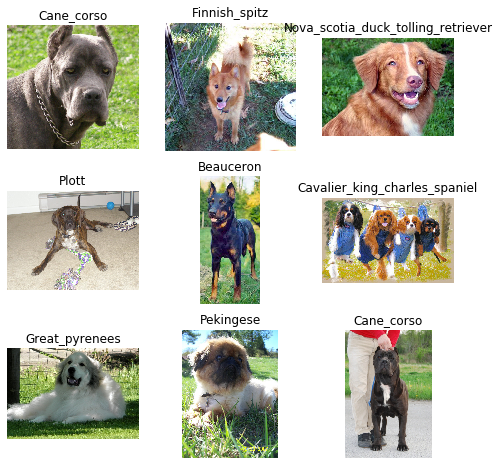

In [9]:
# Plot some of the data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(test_meta))
    img_path = test_meta.iloc[sample_idx, 1]
    label_id = test_meta.iloc[sample_idx, 0]
    label = labels_map.iloc[int(label_id), 1]
    print("label", label, "id", label_id)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(img_path).squeeze(), cmap="gray")
plt.show()

In [24]:
# Create test image loader for HPO
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class DogBreedDataset(Dataset):
    def __init__(self, annotations_file, base_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.base_dir = base_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = int(self.img_labels.iloc[idx, 0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


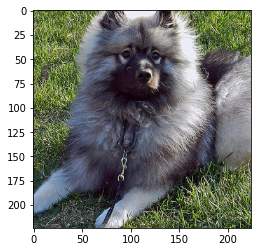

Label: 91


In [39]:
# Display image and label.
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
# Some magic values which are equally the same across multiple examples for different datasets.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_transform = transforms.Compose([
    transforms.Resize([256, ]),
    transforms.CenterCrop(224),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std)])
training_data = DogBreedDataset(annotations_file = 'dogImages/train/meta.csv', base_dir = '.', transform = image_transform)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().numpy().transpose(1,2,0)
label = train_labels[0]
plt.imshow(img*std+mean)
plt.show()
print(f"Label: {label}")

In [63]:
# Upload data to S3 - this step is obsolete but the code can be useful later
# inputs = session.upload_data(path="dogImages", bucket=bucket, key_prefix='dogImages')
# print("input spec (in this case, just an S3 path): {}".format(inputs))

KeyboardInterrupt: 

## Hyperparameter Tuning
Finetuning a pretrained model with hyperparameter tuning. Two hyperparameters were selected for tuning:
- learning rate - to observe when the model learns fasters without overfitting
- batch-size - to find an optimal value for the batch to optimize learning process time

All details are provided in the `hpo.py` script.

In [49]:
# Declare HP ranges and metrics
hyperparameter_ranges = {
    "lr": sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [83]:
# Test raw file execution - if indentation is correct and all dependencies.
# ! python hpo.py

Main Arguments Namespace(batch_size=64, lr=1.0)
Running on Device cpu
--2022-04-12 22:42:48--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.160
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Download successful. Unzipping data
Unzipping succesfull
Creating metadata completed for file dogImages/test/meta.csv
Creating metadata completed for file dogImages/train/meta.csv
Creating metadata completed for file dogImages/valid/meta.csv
Epoch 0, Phase train
^C
Traceback (most recent call last):
  File "hpo.py", line 235, in <module>
    main(args)
  File "hpo.py", line 204, in main
    model=train(model, image_dataset_loaders, loss_criterion, optimizer, device)
  File "hpo.py", line 61, in train
   

In [85]:
# Create estimator
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

In [86]:
# Create tuner
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [87]:
print(inputs)

s3://sagemaker-us-east-1-071394031625/dogImages


In [88]:
tuner.fit(wait=False)

In [89]:
tuner.best_training_job()

Exception: Best training job not available for tuning job: pytorch-training-220412-2325

In [ ]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

Script`train_model.py` implements model profiling and debugging.

In [91]:
hyperparameter_values = {
    "lr": 0.1,
    "batch-size": 32,
}

In [92]:
# Set up debugging rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [93]:
# Set up profiling rules
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [105]:
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    rules=rules,
)

In [102]:
# Test raw file execution - if indentation is correct and all dependencies.
# ! python train_model.py

[2022-04-12 23:39:34.064 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:24956 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-12 23:39:34.177 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:24956 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Running on Device cpu
--2022-04-12 23:39:35--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.240
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Download successful. Unzipping data
Unzipping succesfull
Creating metadata completed for file dogImages/test/meta.csv
Creating metadata completed for file dogImages/train/meta.csv
Creating metadata co

In [ ]:
estimator.fit(wait=True)

2022-04-13 00:01:38 Starting - Starting the training job...
2022-04-13 00:02:07 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......

In [ ]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

In [ ]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

In [ ]:
# Plot a debugging output.
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

import os
# get the autogenerated folder name of profiler report
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]
                       ][0]
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.p2.xlarge") 

In [ ]:
# Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()